# **Modelling and Evaluation**

## Objectives

* Fulfil Business Requirement 2: Accurately predict if a cherry leaf is healthy or contains powdery mildew
* Answer hypothesis #1: Mildew infected leaves will have clear signs of white mildew that can differentiate them from a healthy leaf.

## Inputs

* inputs/datasets/raw/cherry-leaves/train
* inputs/datasets/raw/cherry-leaves/validation
* inputs/datasets/raw/cherry-leaves/test
* image shape .pkl files

## Outputs

* Image augmentation of training dataset
* CNN (Convolutional Neural Network) model tuning using kears-tuner
* Tuned CNN model creation and training.
* Trained model saved and exported to outputs folder
* Learning curve plots for model performance.
* Model evaluation with confusion matrix plot and classification report
* Test prediction on random single image file.

## Additional Comments | Insights | Conclusions
* Objectives met but model is large and may cause issues for streamlit dashboard - this will need to be addressed
* model has 99% predictive accuracy so fulfills success criteria (>97% accuracy)

* The malaria walkthrough project was used as a guide for the structure of this notebook and several functions were used


---

# Setup

## Library Imports

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt
import joblib
import shutil
import random
from matplotlib.image import imread
from IPython.display import Image
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.models import load_model

## Set working directory

Change the working directory from its current folder to its parent folder

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/cherry-mildew-detector/jupyter_notebooks'

Make the parent of the current directory the new current directory

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [5]:
current_dir = os.getcwd()
current_dir

'/workspace/cherry-mildew-detector'

## Set input directories

set paths to specific data folders required in notebook

In [6]:
raw_data_dir = 'inputs/datasets/raw/cherry-leaves'
train_data_dir = 'inputs/datasets/raw/cherry-leaves/train'
val_data_dir = 'inputs/datasets/raw/cherry-leaves/validation'
test_data_dir = 'inputs/datasets/raw/cherry-leaves/test'

print('the raw data directory is', raw_data_dir)
print('the training data directory is', train_data_dir)
print('the validation data directory is', val_data_dir)
print('the test data directory is', test_data_dir)


the raw data directory is inputs/datasets/raw/cherry-leaves
the training data directory is inputs/datasets/raw/cherry-leaves/train
the validation data directory is inputs/datasets/raw/cherry-leaves/validation
the test data directory is inputs/datasets/raw/cherry-leaves/test


## Set output directory

In [7]:
version = 'v1' # change version number for each iteration
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('This version is already available - create a new version if required.')
    pass
else:
    os.makedirs(name=file_path)

This version is already available - create a new version if required.


## Set labels

In [9]:
labels = os.listdir(test_data_dir)
print('Labels for images are', labels)

Labels for images are ['healthy', 'powdery_mildew']


## Set image shape

In [8]:
image_128 = 'outputs/v1/image_shape_half.pkl'
image_50 = 'outputs/v1/image_shape_small.pkl'

---

# Data Augmentation

### Augment training image data and rescale validation and test image data



Define image size and batch size

In [10]:
# Allows size adjustment for tuning
IMG_SIZE = (128, 128) #image_128[:2] #can also be defined with any size eg.(128, 128)  
BATCH_SIZE = 32

Define data augmentation for training data

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=30,  # Random rotation up to 30 degrees
    width_shift_range=0.2,  # Shift width by 20%
    height_shift_range=0.2,  # Shift height by 20%
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom into image
    horizontal_flip=True,  # Flip horizontally
    fill_mode='nearest'  # Fill empty space after transformations
)

Define rescaling for vallidation and test data

In [12]:
val_test_datagen = ImageDataGenerator(rescale=1./255)

Load datasets

In [13]:
train_set = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # One-hot encoding for softmax
)

val_set = val_test_datagen.flow_from_directory(
    val_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_set = val_test_datagen.flow_from_directory(
    test_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # to ensure confusion matrix labels correct
)

train_set.class_indices

Found 2944 images belonging to 2 classes.
Found 420 images belonging to 2 classes.


Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

---

# Hyperparameter Tuning

### Define base CNN model architecture and tune hyperparameters to optimise model

**ChatGPT was used to assist in defining correct code for successful tuning with keras.tuner**

Define image shape

In [30]:
image_shape = (128, 128, 3)  # Modify as needed or use .pkl file

Define model for tuning

In [42]:
def build_model(hp):
    model = Sequential()

    # Input image shape
    model.add(Input(shape=image_shape))

    # First Conv2D layer with tunable filter size
    model.add(Conv2D(
        filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32), 
        kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Conv2D layer
    model.add(Conv2D(
        filters=hp.Int('conv2_filters', min_value=64, max_value=256, step=64), 
        kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Dense layer with tunable units
    model.add(Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))

    # Dropout layer with tunable rate
    model.add(Dropout(hp.Float('dropout', min_value=0.3, max_value=0.5, step=0.1)))

    # Output layer (2 neurons, Softmax activation)
    model.add(Dense(2, activation='softmax'))

    # Compile with tunable learning rate
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

Initialise the tuner

In [43]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory= file_path,
    project_name='cherry_mildew_tuning'
)

Reloading Tuner from outputs/v1/cherry_mildew_tuning/tuner0.json


set early stop if not improving

In [44]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

Run tuner

In [45]:
tuner.search(train_set, validation_data=val_set, epochs=20, callbacks=[early_stop])

Export the best 10 hyperparameter results as a table

In [46]:
# Get the top 10 hyperparameter sets
best_hps = tuner.get_best_hyperparameters(num_trials=10)

# Extract hyperparameters into a DataFrame
hp_data = []
for i, hp in enumerate(best_hps):
    hp_data.append({
        'Trial': i + 1,
        'Conv1 Filters': hp.get('conv1_filters'),
        'Conv2 Filters': hp.get('conv2_filters'),
        'Dense Units': hp.get('dense_units'),
        'Dropout Rate': hp.get('dropout'),
        'Learning Rate': hp.get('learning_rate'),
    })

# Create DataFrame
df = pd.DataFrame(hp_data)

# Save as CSV in the output directory
csv_path = os.path.join(file_path, "hyperparameter_tuning_results.csv")
df.to_csv(csv_path, index=False)

# Display table
print(df)

print(f"Results saved to: {csv_path}")

   Trial  Conv1 Filters  Conv2 Filters  Dense Units  Dropout Rate  \
0      1             32            128          128           0.4   
1      2             64            256          128           0.5   
2      3            128            256          192           0.4   
3      4             96            192           64           0.3   
4      5             32            256          256           0.3   
5      6             96            256          256           0.3   
6      7             96            192           64           0.3   
7      8             32             64          128           0.4   
8      9             96            256          256           0.3   
9     10             96             64          128           0.3   

   Learning Rate  
0          0.001  
1          0.001  
2          0.001  
3          0.001  
4          0.001  
5          0.001  
6          0.001  
7          0.001  
8          0.001  
9          0.001  
Results saved to: outputs/v1/hy

Get the best model from hyperparameter tuning

In [47]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0] # best hyperparameters
best_model = tuner.hypermodel.build(best_hp) # build model from best hyperparameters

Display model summary

In [48]:
best_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,783,874 (56.40 MB)

 Trainable params: 14,783,874 (56.40 MB)

 Non-trainable params: 0 (0.00 B)

#### **NB: tuning results removed at this point as files too large and causing issues for workspace**

---

# Model training

### Uses best CNN model architecture from top hyperparameter tuning result

Define image shape

In [14]:
image_shape = (128, 128, 3)  # Modify as needed or use .pkl file

Define best model

In [15]:
def create_tf_model():
    model = Sequential()

    # Input image shape
    model.add(Input(shape=image_shape))

    # First Conv2D layer with 32 filters
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Conv2D layer with 128 filters
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Dense layer with 128 dense units
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    # Dropout layer with dropout rate of 0.4
    model.add(Dropout(0.4))

    # Output layer (2 neurons, Softmax activation)
    model.add(Dense(2, activation='softmax'))

    # Adam optimiser has default 0.001 learning rate
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


Set early stop if not improving

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Fit model for model training

In [17]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          validation_data=val_set,
          callbacks=[early_stop],
          verbose=1
          )

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 631ms/step - accuracy: 0.6043 - loss: 0.9776 - val_accuracy: 0.9810 - val_loss: 0.0876
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 632ms/step - accuracy: 0.9627 - loss: 0.1478 - val_accuracy: 0.9905 - val_loss: 0.0354
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 630ms/step - accuracy: 0.9824 - loss: 0.0600 - val_accuracy: 0.9952 - val_loss: 0.0113
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 630ms/step - accuracy: 0.9826 - loss: 0.0578 - val_accuracy: 1.0000 - val_loss: 6.7657e-04
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 629ms/step - accuracy: 0.9826 - loss: 0.0532 - val_accuracy: 0.9976 - val_loss: 0.0087
Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 628ms/step - accuracy: 0.9921 - loss: 0.0383 - val_accuracy: 0.9857 - val_loss: 0.0366
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 631ms/step - accuracy: 0.9891 - loss: 0.0342 - val_accuracy: 0.9929 - val_loss: 0.0119


Save model

In [18]:
model.save('outputs/v1/mildew_detector_model.h5')

---

# Model Evaluation

## Model Learning Curve

Generate loss and accuracy plots

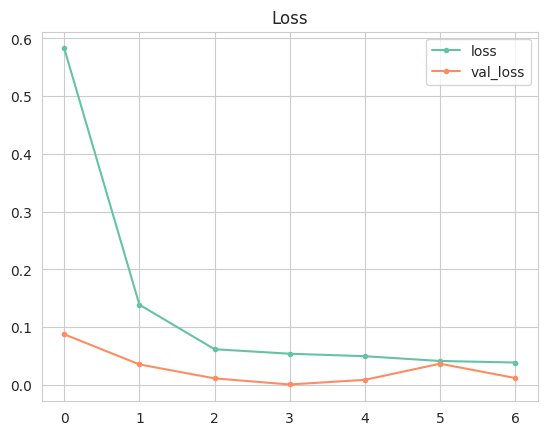

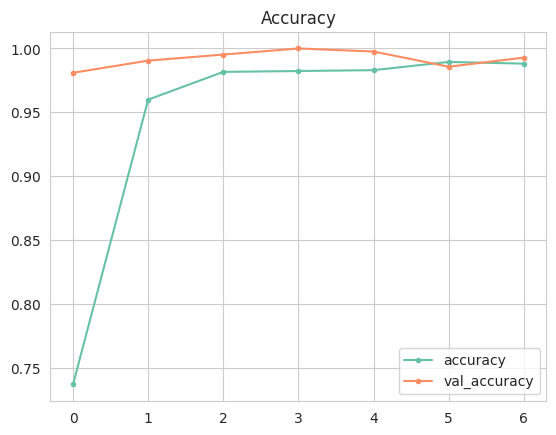

In [19]:
# code from CI malaria walkthrough project with minimal adjustment

losses = pd.DataFrame(model.history.history)

# Set Seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("Set2")

# Plot Loss
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")

# Plot Accuracy
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Confusion Matrix

Generate confusion matrix

True Label: 0, Predicted: 1, Probabilities: [1.1448683e-05 9.9998856e-01]
True Label: 0, Predicted: 0, Probabilities: [9.9999821e-01 1.8126094e-06]
True Label: 0, Predicted: 1, Probabilities: [3.5480573e-04 9.9964523e-01]
True Label: 0, Predicted: 0, Probabilities: [9.9999535e-01 4.6055129e-06]
True Label: 0, Predicted: 1, Probabilities: [0.00155328 0.99844676]


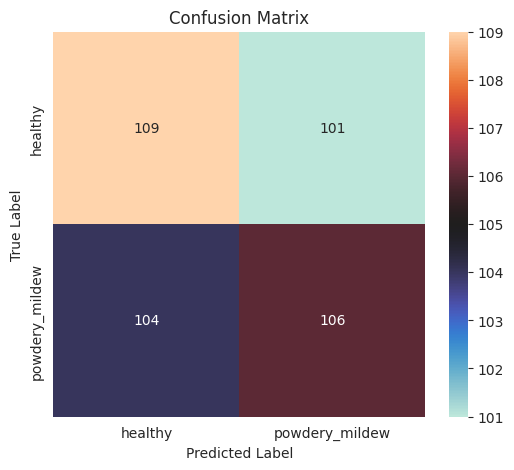

                precision    recall  f1-score   support

       healthy       0.51      0.52      0.52       210
powdery_mildew       0.51      0.50      0.51       210

      accuracy                           0.51       420
     macro avg       0.51      0.51      0.51       420
  weighted avg       0.51      0.51      0.51       420



In [57]:
# Code developed with assistance from ChatGPT

# Ensure predictions are class labels (0 or 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print a few predictions with true labels
for i in range(5):  # Check first 5 samples
    print(f"True Label: {y_true[i]}, Predicted: {y_pred_classes[i]}, Probabilities: {y_pred[i]}")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix with correct labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="icefire", 
            xticklabels=list(val_set.class_indices.keys()), 
            yticklabels=list(val_set.class_indices.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=list(val_set.class_indices.keys())))

**NB: The above confusion matrix  and classifcation report output has code issue as noted in final conclusions in the section below.**

# Single Image test

## Evaluation

Load saved model

In [24]:
model = load_model('outputs/v1/mildew_detector_model.h5')

Evaluate model on test set

In [25]:
evaluation = model.evaluate(test_set)

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9927 - loss: 0.0185


Save evaluation pickle

In [26]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Image test
**code based on CI malaria walkthrough project and refactored with assistance from ChatGPT**

Load a random image as PIL

Class indices mapping: {'healthy': 0, 'powdery_mildew': 1}
Image shape: (128, 128), Image mode: RGB


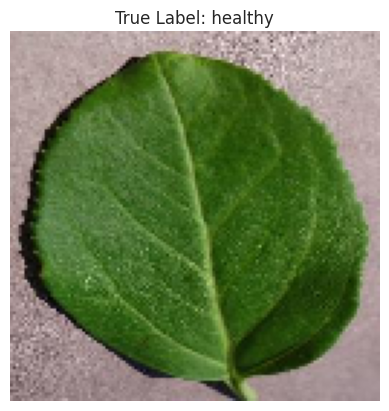

In [62]:
# Generate a random pointer between 0 and 421 (since index starts at 0)
pointer = random.randint(0, 421)  

# Verify class indices mapping
print("Class indices mapping:", train_set.class_indices)

# Load class labels
class_labels = list(train_set.class_indices.keys())  # ['healthy', 'powdery_mildew']

# Randomly select an image from one of the classes
label = random.choice(class_labels)  # Randomly choose between 'healthy' and 'powdery_mildew'

# Load the image
image_path = os.path.join(test_data_dir, label, os.listdir(os.path.join(test_data_dir, label))[pointer])
pil_image = image.load_img(image_path, target_size=image_shape, color_mode='rgb')

print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')

# Display image
plt.imshow(pil_image)
plt.title(f"True Label: {label}")
plt.axis('off')
plt.show()


Convert image to array and prepare for prediction

In [63]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0) / 255.0 
print(my_image.shape)

(1, 128, 128, 3)


Predict class probabilities

In [64]:
# Make prediction
pred_proba = model.predict(my_image)[0]  # Get softmax output (2 values)

# Interpret prediction
pred_class_idx = np.argmax(pred_proba)  # Get index of highest probability
pred_class = class_labels[pred_class_idx]  # Convert index to label

# Print results
print(f"True Label: {label}")
print(f"Predicted Class: {pred_class} with probability {pred_proba[pred_class_idx]:.4f}")
print(f"Raw prediction output: {pred_proba}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
True Label: healthy
Predicted Class: healthy with probability 1.0000
Raw prediction output: [9.9999797e-01 2.0653813e-06]


---

# Conclusions and Next Steps

Conclusions: 
* Business requirement #2 has been fulfilled: predicted model accuracy is 99%
* Model is large and may be too big for streamlit dashboard
* Confusion matrix result is a concern and conflicts with all other model evaluation results. This suggests an issue with the code or a possibility of over-fitting.
**UPDATE**: confusion matrix result of code issue and resolved by including 'shuffle=False' parameter when loading datasets. Correct code used for final model (v5) evaluation in M&E-model_optimisation notebook.


Next steps:
* Train same model architecture on smaller image size to see if improves fit and size of model
* Investigate confusion matrix code to look for cause of conflicting output.
* Build streamlit dashboard to assess size limitations of trained models